In [1]:
import numpy  as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from io import BytesIO
from PIL import Image

In [2]:
zip_path = "German Traffic Sign Recognition Benchmark.zip"

images = []
labels = []

# open the zip file
with zipfile.ZipFile(zip_path, 'r') as z:
    # load Train.csv
    with z.open("Train.csv") as f:
        df = pd.read_csv(f)
        print("Train.csv columns:", df.columns.tolist())
        print(df.head())

    # get image file paths and labels
    for _, row in df.iterrows():
        img_path = row["Path"]  # 'Path' column contains folder path to image
        label = row["ClassId"]  # 'ClassId' column contains the label
        
        # open image from ZIP
        with z.open(img_path) as img_file:
            img = Image.open(BytesIO(img_file.read())).convert("RGB")
            img = img.resize((32, 32))
            images.append(np.array(img))
            labels.append(label)

Train.csv columns: ['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path']
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  


In [3]:
# convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (39209, 32, 32, 3)
Labels shape: (39209,)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  int64 
 7   Path     39209 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.4+ MB


In [5]:
df.isnull().sum()

Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
images = images/255.0

In [9]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

In [10]:
# one -hot encode labels
y_train = to_categorical(y_train)
y_val= to_categorical(y_val)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)

Training data shape: (31367, 32, 32, 3)
Validation data shape: (7842, 32, 32, 3)


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
datagen= ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1)

datagen.fit(X_train)

# Build CNN Model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [14]:
model =Sequential([
    Conv2D(32,(3,3),activation ='relu',input_shape=(32,32,3)),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Fully Connected Layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')
])

model.summary()

C:\Users\Lalit Karki\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         409,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 486,475 (1.86 MB)

 Trainable params: 486,475 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

# Complie Model

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
model.compile(optimizer='adam' ,loss = 'categorical_crossentropy',metrics=['accuracy'])

In [17]:
# Early stopping callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [18]:
# Train Model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=15,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1)

C:\Users\Lalit Karki\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 201s 201ms/step - accuracy: 0.1826 - loss: 3.0171 - val_accuracy: 0.7229 - val_loss: 0.8849
Epoch 2/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 95s 192ms/step - accuracy: 0.6500 - loss: 1.0848 - val_accuracy: 0.9606 - val_loss: 0.1676
Epoch 3/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 96s 195ms/step - accuracy: 0.8401 - loss: 0.4944 - val_accuracy: 0.9811 - val_loss: 0.0665
Epoch 4/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 92s 186ms/step - accuracy: 0.8969 - loss: 0.3277 - val_accuracy: 0.9926 - val_loss: 0.0354
Epoch 5/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 92s 188ms/step - accuracy: 0.9251 - loss: 0.2381 - val_accuracy: 0.9923 - val_loss: 0.0296
Epoch 6/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 93s 188ms/step - accuracy: 0.9411 - loss: 0.1942 - val_accuracy: 0.9949 - val_loss: 0.0206
Epoch 7/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 91s 185ms/step - accuracy: 0.9479 - loss: 0.1650 - val_accuracy: 0.9964 - val_loss: 0.0139
Epoch 8/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 92s 187ms/step - accuracy: 0.9557 - loss: 

In [19]:
# Evaluate Model v
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"\n Validation Accuracy: {val_acc*100:.2f}%")


 Validation Accuracy: 99.83%


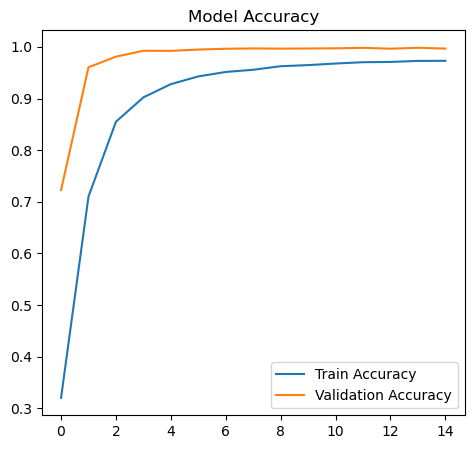

In [20]:
# Plot a graph of Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()


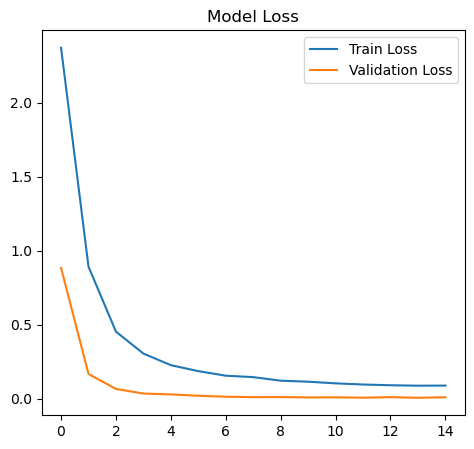

In [21]:
# Plot a graph of loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix

In [23]:
y_pred = np.argmax(model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)

246/246 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step


In [24]:
cm = confusion_matrix(y_true, y_pred)

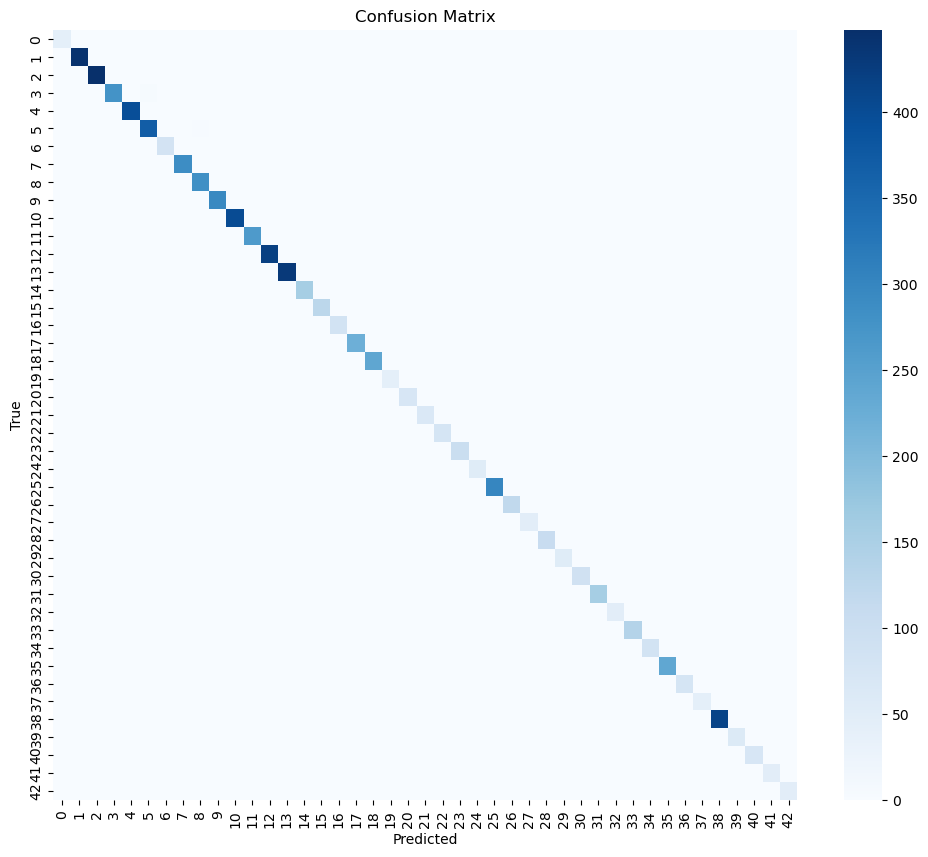

In [25]:
plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()